
### Analysis Real Estate Prices in Hong Kong
Author: KW.Loh, MsC Comp7103 Assignment Sem 1 2023<br> 
Email :mweng02@connect.hku.hk

In [1]:
### Library 
import numpy as np, pandas as pd , datetime as dt, pickle ,seaborn as sns
import matplotlib.pyplot as plt, matplotlib.gridspec as gs
from matplotlib.image import imread
import warnings
warnings.filterwarnings('ignore')

#### STEP 1 Dataset : Residential real estate sold in the period 2016 - 2019 in Hong Kong 

The transaction dataset were obtained from a vendor that comprise of residential transaction in Hong kong from 2016 to 2019. There are 230,000++ records in the datasets and first fed into PreProcessing.Py to cleansing the datasets and the following new features had been created: <br> a) New Sales and Resales <br> b) Property_Type <br> c) Buildng Age <br> d) UnitSize <br> e) Floor Type <br>

At the same time, I had developed GeoCoder.py to call the GOOGLE MAP API to collect the lattitude and longitude of the distinct projectname and selected POI such as MTR and stored at JSON file. Next, I had further created a few more feature based on the distance between the POI and selected project name. </br>  

All the data are stored in Data/ Folder and the details on how to execute the two python scripts are available in the PreProcessing.Py. 
<br>


In [2]:
### The dataset has been processed and pre-clean in PreProcessing.Py
with open('Data/TransactionData.pkl', 'rb') as file_name:
    HK = pickle.load(file_name)

In [3]:
HK.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 238046 entries, 2019-12-31 to 2016-01-01
Data columns (total 27 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Project_Name        238046 non-null  object 
 1   combined_address    238046 non-null  object 
 2   INST_DATE           238046 non-null  object 
 3   Sale_Type           238046 non-null  object 
 4   Property_Type       238046 non-null  object 
 5   Sale_Year           238046 non-null  int64  
 6   D_CODE              238046 non-null  object 
 7   BuildingAge         238046 non-null  int64  
 8   FLOOR               238046 non-null  int64  
 9   FloorType           238046 non-null  int64  
 10  UnitSize            238046 non-null  int64  
 11  TOTNFA              238046 non-null  float64
 12  lat                 238046 non-null  float64
 13  long                238046 non-null  float64
 14  MRT                 238046 non-null  object 
 15  quarter           

In [4]:
# Real estate size statistics(In square feet)# Price per square-meter statistics
HK.describe().applymap('{:,.2f}'.format).T

,count,mean,std,min,25%,50%,75%,max
Sale_Year,"238,046.00","2,017.47",1.11,"2,016.00","2,017.00","2,017.00","2,018.00","2,019.00"
BuildingAge,"238,046.00",1.89,1.24,0.00,1.00,2.00,3.00,3.00
FLOOR,"238,046.00",17.01,89.85,0.00,7.00,14.00,24.00,"43,412.00"
FloorType,"238,046.00",1.83,1.06,0.00,1.00,2.00,3.00,4.00
UnitSize,"238,046.00",1.98,0.88,1.00,1.00,2.00,2.00,5.00
TOTNFA,"238,046.00",562.10,"1,212.37",79.00,379.00,491.00,638.00,"568,550.00"
lat,"238,046.00",22.49,2.17,-43.60,22.30,22.33,22.38,54.81
long,"238,046.00",112.12,20.00,-121.89,114.11,114.17,114.20,172.72
Distance_To_CBD,"238,046.00",243.55,"2,237.70",0.25,4.95,9.88,17.41,"26,325.00"
Distance_TO_MRT,"238,046.00",3.24,22.15,0.00,0.26,0.45,0.84,200.00


In [5]:
NFA_variance =  10 *1212.37
Net_PSF_variance = 10 *6242.62	
Price_variance = 10 * 11943340.83

In [6]:
HK = HK[(HK['NET_PSF'] <Net_PSF_variance) & (HK['TOTNFA'] > 200) & (HK['TOTNFA'] <NFA_variance) & (HK['Transaction_Price'] < Price_variance)
        &(HK['lat'] > 22) &(HK['long'] > 114)&(HK['FLOOR'] < 100) &(HK['Transaction_Price'] > 2000000)]
HK = HK[(HK['NET_PSF'] != 0) & (HK['Distance_TO_MRT'] != 200)] 
#HK = HK.drop(["CBD"],axis =1)
HK['MRT'] = HK['MRT'].astype(str)


#### STEP 2 DATA MINING
The Observation from the dataset description <br>
#1) 75% of transaction are below 700 sqft ~ median is ~500 sqft ~ 75% stay 638 sqft <br>
#2) The psf is going up from 11K in 2016 to 15K in 2019 and average transaction per month is about 5000 <br> 
#3) 75% percentile is 9 million. Median is HKD 6 million <br>
#4) Only ~25% are new sales. Out of the remaining secondary sales, 43% of the transaction are 20 years old age building.

Next, investigate the 3 questions in mind --> 
#6) Near MTR station has price premium about HKD 2000 per premium (500 m radius) for project more than 20 years old. No concrete MRT premium for new project<br>
#7) Most expensive psf more focus on Kowloon Area (from the heat map).


In [7]:
# Real estate size statistics(In square feet)# Price per square-meter statistics
HK.describe().applymap('{:,.2f}'.format).T

,count,mean,std,min,25%,50%,75%,max
Sale_Year,"208,438.00","2,017.47",1.11,"2,016.00","2,016.00","2,017.00","2,018.00","2,019.00"
BuildingAge,"208,438.00",1.88,1.24,0.00,1.00,2.00,3.00,3.00
FLOOR,"208,438.00",17.04,12.93,0.00,7.00,14.00,24.00,89.00
FloorType,"208,438.00",1.83,1.07,0.00,1.00,2.00,3.00,4.00
UnitSize,"208,438.00",2.01,0.89,1.00,1.00,2.00,2.00,5.00
TOTNFA,"208,438.00",565.93,306.53,201.00,381.00,496.00,646.00,"11,397.00"
lat,"208,438.00",22.34,0.06,22.20,22.30,22.32,22.37,22.55
long,"208,438.00",114.17,0.07,114.00,114.14,114.17,114.21,114.29
Distance_To_CBD,"208,438.00",10.24,6.52,0.25,4.72,8.87,12.81,30.05
Distance_TO_MRT,"208,438.00",0.68,0.91,0.00,0.24,0.41,0.72,12.58


In [8]:
HK["UnitSize"].value_counts()

2    106103
1     59780
3     27786
4     11262
5      3507
Name: UnitSize, dtype: int64

In [9]:
HK["FloorType"].value_counts()

1    79618
2    59876
3    37346
4    17588
0    14010
Name: FloorType, dtype: int64

In [10]:
HK["BuildingAge"].value_counts()

3    99634
0    49821
2    34572
1    24411
Name: BuildingAge, dtype: int64

In [11]:
HK["below_value"].value_counts()

0    207383
1      1055
Name: below_value, dtype: int64

In [12]:
HK["Property_Type"].value_counts()

E    161488
B     46950
Name: Property_Type, dtype: int64

In [13]:
HK["stair"].value_counts()

0    207980
1       458
Name: stair, dtype: int64

In [14]:
HK["parking"].value_counts()

0    204542
1      3896
Name: parking, dtype: int64

In [15]:
HK["duplex"].value_counts()

0    208026
1       412
Name: duplex, dtype: int64

In [16]:
HK["quarter"].value_counts()


2016-Q3    19208
2018-Q2    16486
2018-Q1    14921
2017-Q4    14847
2019-Q1    14783
2017-Q2    14601
2017-Q1    14264
2016-Q4    13641
2019-Q2    13529
2016-Q2    12910
2017-Q3    12304
2019-Q4    11110
2018-Q3    10943
2019-Q3    10478
2018-Q4     7899
2016-Q1     6514
Name: quarter, dtype: int64

#### Q1: New Home or Resale ? 

4859.636371300196

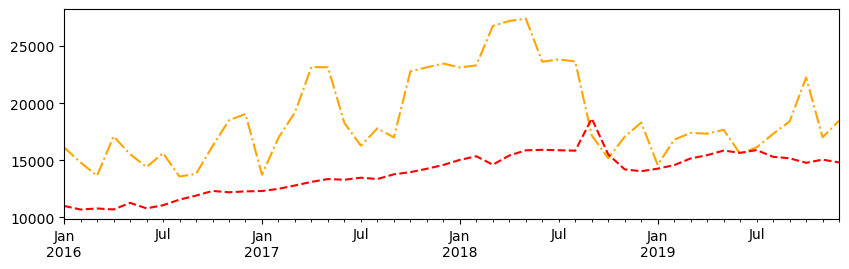

In [17]:
new_psf = HK[(HK['Sale_Type']=='NEW')].resample('1M').mean()
old_psf = HK[(HK['Sale_Type']=='RESALE')].resample('1M').mean()
difference_psf = new_psf['NET_PSF'].mean() - old_psf['NET_PSF'].mean()

fig = plt.figure(1, figsize=(10,6))
grid = gs.GridSpec(2, 1, height_ratios=[1,1])
ax1 = plt.subplot(grid[0,0])

new_psf ['NET_PSF'].plot(ls='-.', c='orange', label='NEAR_MRT', ax=ax1)
old_psf['NET_PSF'].plot(ls='--', c='red', label='NOT NEAR MRT', ax=ax1)

new_psf['NET_PSF'].mean() - old_psf['NET_PSF'].mean()

In [18]:
HK['Sale_Type'].groupby(HK['BuildingAge']).value_counts(sort=True)
# 3 is more than 20 years 
# 2 is 10- 20 years
# 1 is within 10 years 
# 0 new flat 

BuildingAge  Sale_Type
0            NEW          49821
1            RESALE       24411
2            RESALE       34572
3            RESALE       99634
Name: Sale_Type, dtype: int64

In [19]:
HK['Sale_Type'].groupby(HK['Sale_Year']).value_counts()

Sale_Year  Sale_Type
2016       RESALE       38740
           NEW          13533
2017       RESALE       43290
           NEW          12726
2018       RESALE       42399
           NEW           7850
2019       RESALE       34188
           NEW          15712
Name: Sale_Type, dtype: int64

<Axes: ylabel='Sale_Type'>

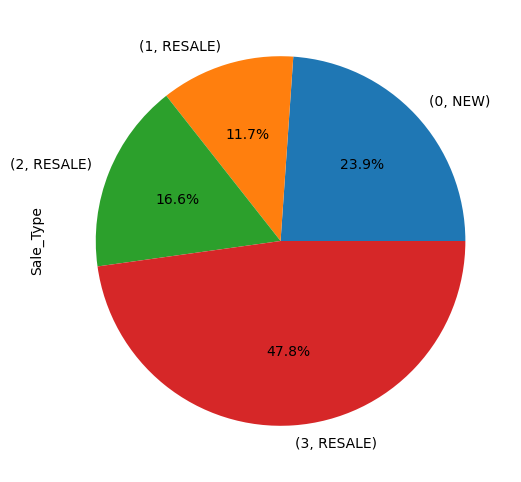

In [20]:
HK['Sale_Type'].groupby(HK['BuildingAge']).value_counts().plot(kind='pie',autopct= '%1.1f%%', figsize=(8,6))

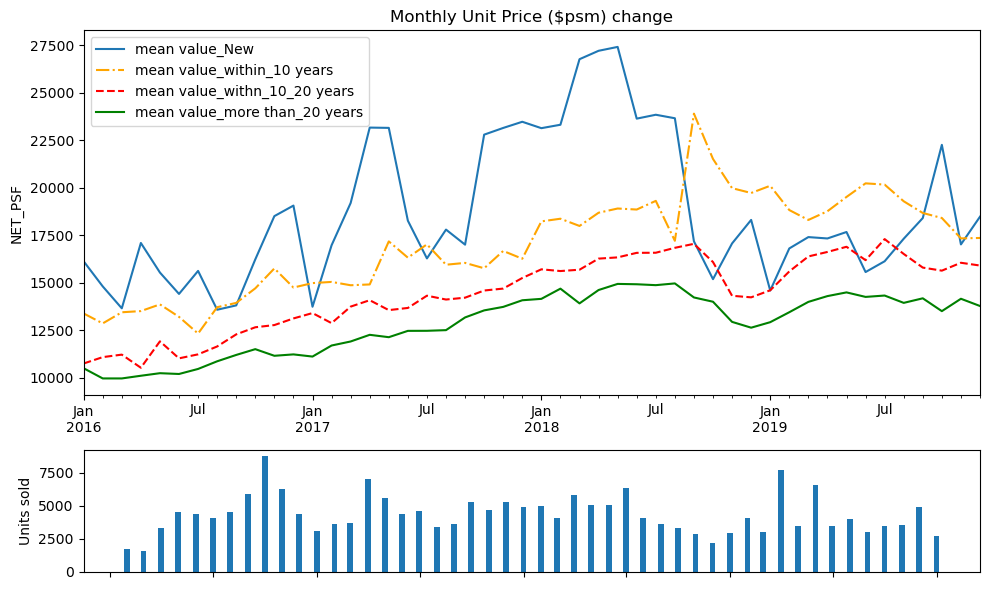

In [21]:
minton_0 = HK[HK['BuildingAge']==0].resample('1M').mean()
minton_1 = HK[HK['BuildingAge']==1].resample('1M').mean()
minton_2 = HK[HK['BuildingAge']==2].resample('1M').mean()
minton_3 = HK[HK['BuildingAge']==3].resample('1M').mean()
minton_count = HK.resample('1M').count()
fig = plt.figure(1, figsize=(10,6))
grid = gs.GridSpec(2, 1, height_ratios=[3,1])
ax1 = plt.subplot(grid[0,0])
ax2 = plt.subplot(grid[1,0])
minton_0['NET_PSF'].plot(ls='-', label='mean value_New', ax=ax1)
minton_1['NET_PSF'].plot(ls='-.', c='orange', label='mean value_within_10 years', ax=ax1)
minton_2['NET_PSF'].plot(ls='--', c='red', label='mean value_withn_10_20 years', ax=ax1)
minton_3['NET_PSF'].plot(ls='-', c='green', label='mean value_more than_20 years', ax=ax1)
ax1.set_title('Monthly Unit Price ($psm) change')
ax1.set_ylabel('NET_PSF')
ax1.legend(loc='upper left')
ax2.bar(minton_count.index, minton_count['Project_Name'], width=10)
ax2.set_ylabel('Units sold')
ax2.set_xticklabels('')
plt.tight_layout()
plt.show()

In [22]:
pricechange_new = minton_0['NET_PSF'].T[minton_0['NET_PSF'].index[-1]] / minton_0['NET_PSF'].T[minton_0['NET_PSF'].index[0]] -1
pricechange_10 = minton_1['NET_PSF'].T[minton_1['NET_PSF'].index[-1]] / minton_1['NET_PSF'].T[minton_1['NET_PSF'].index[0]] -1
pricechange_20 = minton_2['NET_PSF'].T[minton_2['NET_PSF'].index[-1]] / minton_2['NET_PSF'].T[minton_2['NET_PSF'].index[0]] -1
pricechange_old = minton_3['NET_PSF'].T[minton_3['NET_PSF'].index[-1]] / minton_3['NET_PSF'].T[minton_3['NET_PSF'].index[0]] -1
pricechange_new,pricechange_10,pricechange_20,pricechange_old


(0.14541642262888477,
 0.2966063697597754,
 0.47897571600779965,
 0.3116378530532493)


### Q2 ) Near MRT or Not -->Location Premium ?

In [23]:
STATION = HK.groupby('MRT')[['NET_PSF','lat','long','Distance_TO_MRT']].mean().reset_index()

In [24]:
top_dollars = STATION.sort_values('NET_PSF', ascending=False).iloc[:10]
top_dollars

,MRT,NET_PSF,lat,long,Distance_TO_MRT
28,Kowloon Station,30424.970639,22.304123,114.162350,0.183858
0,Admiralty Station,24440.251046,22.275125,114.163841,0.624146
21,Hong Kong Station,23211.881988,22.281785,114.152640,0.467807
3,Central Station,22778.816921,22.277348,114.153889,0.719207
48,Ocean Park Station,22395.537931,22.231245,114.200786,3.601907
45,Nam Cheong Station,22387.631611,22.327371,114.154017,0.122310
15,HKU Station,21660.649215,22.285635,114.135577,0.291537
55,Sai Ying Pun Station,21001.805928,22.285640,114.142584,0.309358
29,Kowloon Tong Station,20816.603252,22.338949,114.175305,0.633623
43,Mong Kok East Station,20678.858580,22.320450,114.178667,0.803158


In [25]:
#OVERALL = HK[(HK['Distance_TO_MRT'] < 0.5)].mean()
#OVERALL_ = HK[(HK['Distance_TO_MRT'] > 0.5)].mean()

NEW = HK[(HK['BuildingAge'] == 0 ) & (HK['Distance_TO_MRT'] < 0.5)].resample('1M').mean()
NEW_ = HK[(HK['BuildingAge'] == 0 ) & (HK['Distance_TO_MRT'] > 0.5)].resample('1M').mean()

WITHIN10 = HK[(HK['BuildingAge'] == 1 ) & (HK['Distance_TO_MRT'] < 0.5)].resample('1M').mean()
WITHIN10_ = HK[(HK['BuildingAge'] == 1 ) & (HK['Distance_TO_MRT'] > 0.5)].resample('1M').mean()

WITHIN20 = HK[(HK['BuildingAge'] == 2 ) & (HK['Distance_TO_MRT'] < 0.5)].resample('1M').mean()
WITHIN20_ = HK[(HK['BuildingAge'] == 2 ) & (HK['Distance_TO_MRT'] > 0.5)].resample('1M').mean()

OTHER = HK[(HK['BuildingAge'] == 3 ) & (HK['Distance_TO_MRT'] < 0.5)].resample('1M').mean()
OTHER_ = HK[(HK['BuildingAge'] == 3 ) & (HK['Distance_TO_MRT'] > 0.5)].resample('1M').mean()


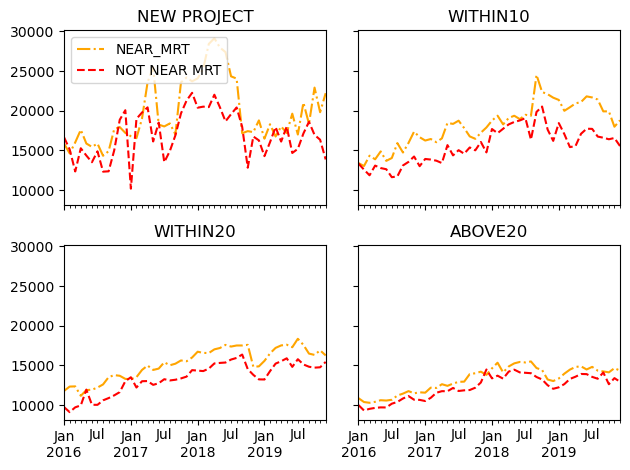

In [26]:
fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True)
ax1, ax2, ax3, ax4 = axes.flatten()

NEW['NET_PSF'].plot(ls='-.', c='orange', label='NEAR_MRT', ax=ax1)
NEW_['NET_PSF'].plot(ls='--', c='red', label='NOT NEAR MRT', ax=ax1)
WITHIN10['NET_PSF'].plot(ls='-.', c='orange', label='NEAR_MRT', ax=ax2)
WITHIN10_['NET_PSF'].plot(ls='--', c='red', label='NOT NEAR MRT', ax=ax2)
WITHIN20['NET_PSF'].plot(ls='-.', c='orange', label='NEAR_MRT', ax=ax3)
WITHIN20_['NET_PSF'].plot(ls='--', c='red', label='NOT NEAR MRT', ax=ax3)
OTHER['NET_PSF'].plot(ls='-.', c='orange', label='NEAR_MRT', ax=ax4)
OTHER_['NET_PSF'].plot(ls='--', c='red', label='NOT NEAR MRT', ax=ax4)
ax1.set_title('NEW PROJECT')
ax2.set_title('WITHIN10')
ax3.set_title('WITHIN20')
ax4.set_title('ABOVE20')
ax2.set_ylabel('NET_PSF')
ax1.legend(loc='upper left')
plt.tight_layout()
plt.show()


In [27]:
PREMIUM_NEW = NEW - NEW_
PREMIUM_10 = WITHIN10 - WITHIN10_
PREMIUM_20 = WITHIN20 - WITHIN20_
PREMIUM_OLD = OTHER - OTHER_

<Axes: >

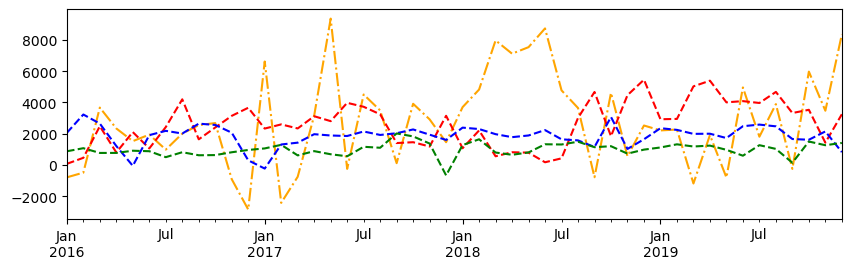

In [28]:
fig = plt.figure(1, figsize=(10,6))
grid = gs.GridSpec(2, 1, height_ratios=[1,1])
ax1 = plt.subplot(grid[0,0])

PREMIUM_NEW['NET_PSF'].plot(ls='-.', c='orange', label='NEAR_MRT', ax=ax1)
PREMIUM_10['NET_PSF'].plot(ls='--', c='red', label='NOT NEAR MRT', ax=ax1)
PREMIUM_20['NET_PSF'].plot(ls='--', c='blue', label='NOT NEAR MRT', ax=ax1)
PREMIUM_OLD['NET_PSF'].plot(ls='--', c='green', label='NOT NEAR MRT', ax=ax1)

In [29]:
PREIMIUM = [PREMIUM_NEW['NET_PSF'].mean(), PREMIUM_10['NET_PSF'].mean(),PREMIUM_20['NET_PSF'].mean(),PREMIUM_OLD['NET_PSF'].mean()]
PREIMIUM

[2756.817294186057, 2614.5648865139174, 1861.1191309551768, 991.2869556892406]

In [30]:
#3 --> before 2005 
#2--> 2005 -2010
#1 --> 2010-2016
#0 --> 2017 and above 

#### Machine Learning Real Estate Prediction 
#### Step 3: Feature Selection and Drop the Column 

In [31]:
from sklearn import preprocessing
from sklearn import metrics 
from sklearn.model_selection  import train_test_split
from sklearn.model_selection  import KFold, cross_val_score,RepeatedKFold
from sklearn.tree import DecisionTreeRegressor
from sklearn import linear_model

In [32]:
HK.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 208438 entries, 2019-12-31 to 2016-01-01
Data columns (total 27 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Project_Name        208438 non-null  object 
 1   combined_address    208438 non-null  object 
 2   INST_DATE           208438 non-null  object 
 3   Sale_Type           208438 non-null  object 
 4   Property_Type       208438 non-null  object 
 5   Sale_Year           208438 non-null  int64  
 6   D_CODE              208438 non-null  object 
 7   BuildingAge         208438 non-null  int64  
 8   FLOOR               208438 non-null  int64  
 9   FloorType           208438 non-null  int64  
 10  UnitSize            208438 non-null  int64  
 11  TOTNFA              208438 non-null  float64
 12  lat                 208438 non-null  float64
 13  long                208438 non-null  float64
 14  MRT                 208438 non-null  object 
 15  quarter           

In [33]:
HK = pd.get_dummies(HK, columns=['quarter', 
                                    #'Sale_Year_a'
                                   ], drop_first=False)

In [34]:
le = preprocessing.LabelEncoder()
for column in HK.describe(include='object').columns:
    HK[column] = le.fit_transform(HK[column])

In [35]:
HK = HK.fillna('')

In [36]:
pearson = HK.corr('pearson')
pearson.iloc[-1][:-1].sort_values()

quarter_2016-Q3      -0.075598
quarter_2018-Q2      -0.069538
quarter_2018-Q1      -0.065887
quarter_2017-Q4      -0.065711
quarter_2019-Q1      -0.065559
quarter_2017-Q2      -0.065123
quarter_2017-Q1      -0.064311
quarter_2016-Q4      -0.062791
quarter_2019-Q2      -0.062514
quarter_2016-Q2      -0.060971
quarter_2017-Q3      -0.059431
quarter_2018-Q3      -0.055854
quarter_2019-Q3      -0.054590
quarter_2018-Q4      -0.047092
quarter_2016-Q1      -0.042618
long                 -0.033725
parking              -0.032432
UnitSize             -0.029889
TOTNFA               -0.029463
roof                 -0.029374
Sale_Type            -0.027266
BuildingAge          -0.024277
below_value          -0.016322
Transaction_Price    -0.004251
duplex               -0.001904
FLOOR                -0.000620
Project_Name         -0.000444
combined_address      0.000026
stair                 0.001637
Distance_To_School    0.002608
Distance_To_CBD       0.003793
FloorType             0.005057
lat     

In [37]:
# Correlation matrix as heatmap (seaborn)
#fig, ax = plt.subplots(figsize=(14,10))
#sns.heatmap(pearson, annot=True, annot_kws=dict(size=12), vmin=-1, vmax=1, ax=ax, cmap="YlGnBu")
#plt.tight_layout()
#plt.show()

In [38]:
HK_ = HK.drop(['INST_DATE','Project_Name','Sale_Year','MRT','TOTNFA','D_CODE','Transaction_Price','FLOOR','UnitSize',"NET_PSF"],axis =1)
xHK_ = HK.drop(['INST_DATE','Project_Name','Sale_Year','MRT','TOTNFA','D_CODE','Transaction_Price','FLOOR','UnitSize','Distance_TO_MRT',"NET_PSF"],axis =1)
y = HK['NET_PSF']

In [39]:
HK_.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 208438 entries, 2019-12-31 to 2016-01-01
Data columns (total 32 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   combined_address    208438 non-null  int32  
 1   Sale_Type           208438 non-null  int32  
 2   Property_Type       208438 non-null  int32  
 3   BuildingAge         208438 non-null  int64  
 4   FloorType           208438 non-null  int64  
 5   lat                 208438 non-null  float64
 6   long                208438 non-null  float64
 7   Distance_To_CBD     208438 non-null  float64
 8   Distance_TO_MRT     208438 non-null  float64
 9   Distance_To_School  208438 non-null  float64
 10  Distance_To_Mall    208438 non-null  float64
 11  below_value         208438 non-null  int64  
 12  duplex              208438 non-null  int64  
 13  stair               208438 non-null  int64  
 14  parking             208438 non-null  int64  
 15  roof              

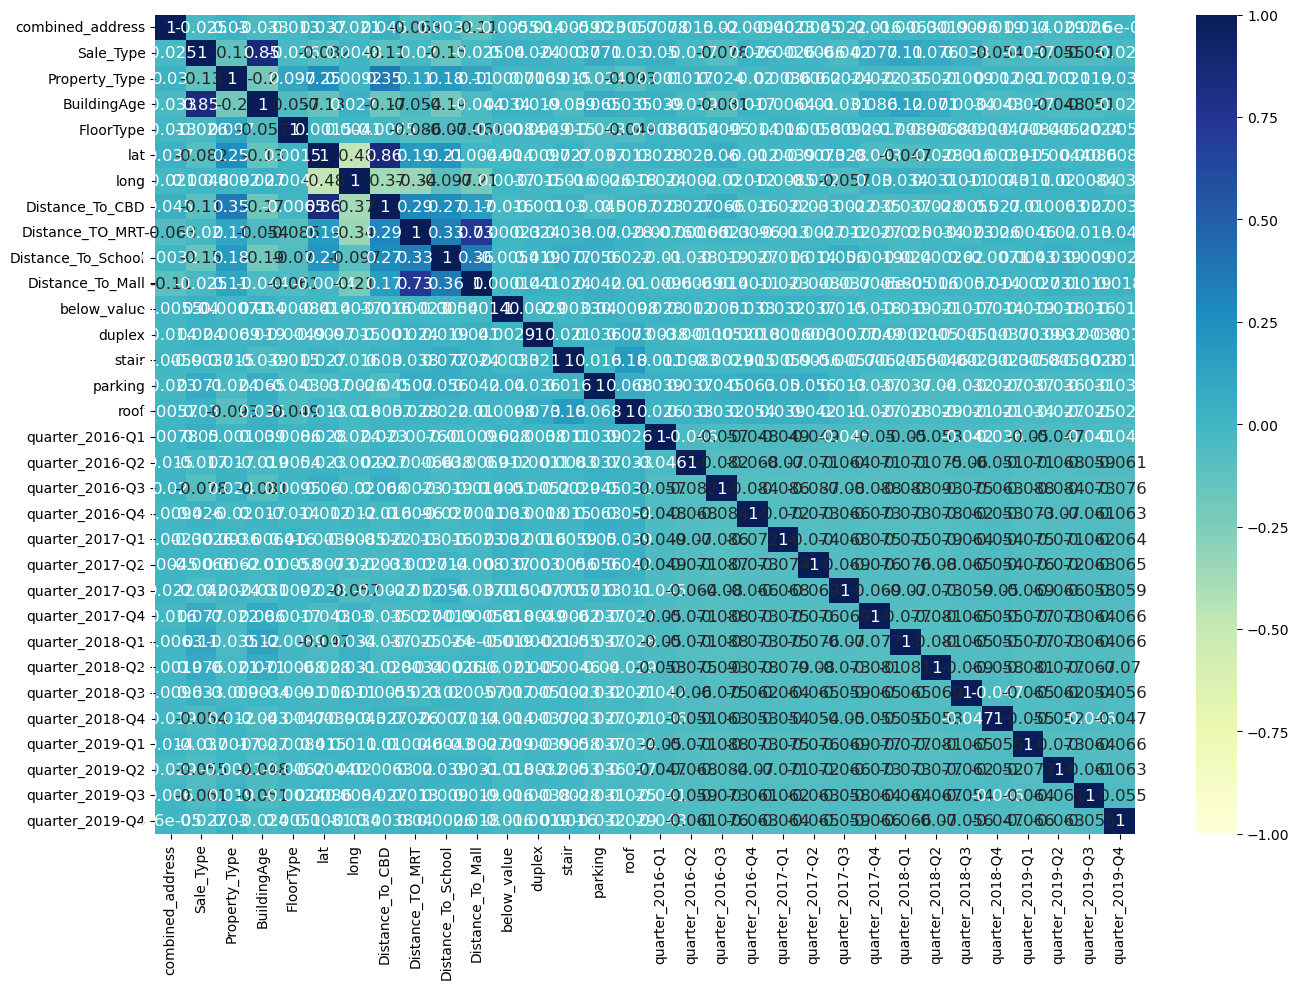

In [40]:
pearson = HK_.corr('pearson')
pearson.iloc[-1][:-1].sort_values()
# Correlation matrix as heatmap (seaborn)
fig, ax = plt.subplots(figsize=(14,10))
sns.heatmap(pearson, annot=True, annot_kws=dict(size=12), vmin=-1, vmax=1, ax=ax, cmap="YlGnBu")
plt.tight_layout()
plt.show()

In [41]:
# Split data into train and test leaving last ten (500) rows for the final evaluation
X_train, X_test, y_train, y_test = train_test_split(HK_.iloc[:-500], y.iloc[:-500], test_size=0.2)
xX_train, xX_test, xy_train, xy_test = train_test_split(xHK_.iloc[:-500], y.iloc[:-500], test_size=0.2)

In [42]:
print('Database size: {:g} \nTrain set size: {:g} \nTest set size: {:g} \nValidate set size: {:g}'
      .format(len(HK_), len(y_train), len(y_test), len(HK_)-(len(y_train)+len(y_test))))

Database size: 208438 
Train set size: 166350 
Test set size: 41588 
Validate set size: 500


In [43]:
# Scale data
scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#### STEP 4 : APPLYING MACHINE LEARNING MODEL

In [44]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree  import DecisionTreeRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import explained_variance_score,mean_squared_error,r2_score

In [45]:
def getmodel(name):
    if name=="tree":
        return DecisionTreeRegressor()
    elif name=="rf":
        return RandomForestRegressor()
    elif name=="et":
        return ExtraTreesRegressor()
    elif name=="lg":
        return LGBMRegressor(n_estimators= 5000, max_depth=20, random_state=123, n_jobs=4, reg_alpha=0.1, reg_lambda=0.9)
    elif name == "gb":
        return GradientBoostingRegressor(loss='absolute_error', max_depth=10, n_estimators=100)

In [46]:
# Train & evaluate model performance
def train_and_evaluate(model, X, y,X_test,y_test):
    model.fit(X, y)
    print('Score on training set: {:g}'.format(model.score(X, y)))
    # k-fold cross validation iterator of 5 folds
    cv = KFold(n_splits=5, shuffle=True, random_state=1)
    scores = cross_val_score(model, X, y, cv=cv)
    print('Score using 5-fold cross-validation:' +'{:g} +/- {:g}'.format(np.mean(scores), np.std(scores)*2)) 
    y_pred = model.predict(X_test)
    return np.mean(scores), np.std(scores)*2,metrics.r2_score(y_test, y_pred),metrics.mean_squared_error(y_test, y_pred)

In [47]:
tree,forest ,clf_et ,clf_gb,lg = getmodel('tree'),getmodel('rf'),getmodel('et'),getmodel("gb"),getmodel("lg")
xtree,xforest ,xclf_et ,xclf_gb,xlg = getmodel('tree'),getmodel('rf'),getmodel('et'),getmodel("gb"),getmodel("lg")
ModelList= [tree,forest,clf_et,clf_gb,lg]
xModelList= [xtree,xforest,xclf_et,xclf_gb,xlg]

In [48]:
R2_train,R2_test,MSE = [],[],[]
for model in ModelList:
    a,b,c,d = train_and_evaluate(model, X_train, y_train.ravel(),X_test,y_test)
    R2_train.append(a)
    R2_test.append(c)
    MSE.append(d) 

Score on training set: 0.974518
Score using 5-fold cross-validation:0.811576 +/- 0.0101995
Score on training set: 0.963676
Score using 5-fold cross-validation:0.874892 +/- 0.00319
Score on training set: 0.974518
Score using 5-fold cross-validation:0.861232 +/- 0.00379418
Score on training set: 0.846267
Score using 5-fold cross-validation:0.825806 +/- 0.00701963
Score on training set: 0.930801
Score using 5-fold cross-validation:0.882477 +/- 0.00158959


In [64]:
R2_train_No_MTR,R2_test_No_MTR,xMSE = [],[],[]
for model in xModelList:
    a,b,c,d = train_and_evaluate(model, xX_train, xy_train.ravel(),xX_test,xy_test)
    R2_train_No_MTR.append(a)
    R2_test_No_MTR.append(c)
    xMSE.append(d) 

Score on training set: 0.974449
Score using 5-fold cross-validation:0.813759 +/- 0.00363598
Score on training set: 0.963589
Score using 5-fold cross-validation:0.875025 +/- 0.0054181
Score on training set: 0.974449
Score using 5-fold cross-validation:0.860507 +/- 0.0042384
Score on training set: 0.847144
Score using 5-fold cross-validation:0.827047 +/- 0.00939147
Score on training set: 0.930618
Score using 5-fold cross-validation:0.882312 +/- 0.00243654


In [65]:
Model = ['DecisionTree','RandomForest','ExtraRandomForest','GradientBoosting','LightGBM']

In [66]:
result_base = pd.DataFrame(columns=['Model','R2_train','R2_test'])
result_xMTR = pd.DataFrame(columns=['Model','R2_train_No_MTR','R2_test_No_MTR'])

In [67]:
result_base['Model'] = Model
result_base['R2_train'] = R2_train
result_base['R2_test'] = R2_test
result_base['MSE'] = MSE

result_xMTR['Model'] = Model
result_xMTR['R2_train_No_MTR'] = R2_train_No_MTR
result_xMTR['R2_test_No_MTR'] = R2_test_No_MTR
result_xMTR['xMSE'] = xMSE 

In [68]:
result_base

,Model,R2_train,R2_test,MSE
0,DecisionTree,0.811576,0.823807,5.475034e+06
1,RandomForest,0.874892,0.882208,3.660257e+06
2,ExtraRandomForest,0.861232,0.868110,4.098343e+06
3,GradientBoosting,0.825806,0.830945,5.253217e+06
4,LightGBM,0.882477,0.889073,3.446936e+06


In [69]:
result_xMTR

,Model,R2_train_No_MTR,R2_test_No_MTR,xMSE
0,DecisionTree,0.813759,0.823760,5.508746e+06
1,RandomForest,0.875025,0.879687,3.760613e+06
2,ExtraRandomForest,0.860507,0.866267,4.180086e+06
3,GradientBoosting,0.827047,0.826517,5.422567e+06
4,LightGBM,0.882312,0.885150,3.589873e+06


In [70]:
feature_importance = clf_et.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

In [71]:
# Feature importance
feature_importance_ = lg.feature_importances_
feature_importance_ = 100.0 * (feature_importance_ / feature_importance_.max())
sorted_idx_ = np.argsort(feature_importance_)
pos_ = np.arange(sorted_idx_.shape[0]) + .5

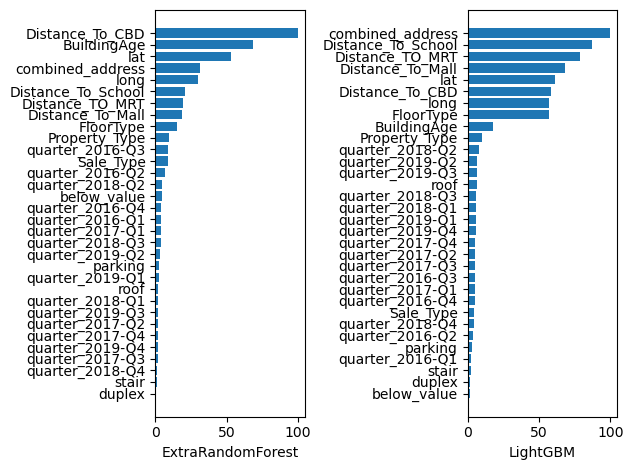

In [72]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=False)
ax1, ax2 = axes.flatten()
ax1.barh(pos, feature_importance[sorted_idx], align='center')
ax2.barh(pos_, feature_importance_[sorted_idx_], align='center')
ax1.set(yticks=pos, yticklabels=np.array(HK_.columns[sorted_idx]))
ax2.set(yticks=pos_, yticklabels=np.array(HK_.columns[sorted_idx_]))
ax1.set_xlabel('ExtraRandomForest')
ax2.set_xlabel('LightGBM')
plt.tight_layout()
plt.show()

### Prediction Unseen Data 

In [73]:
# Pedict price for new apartments (not seen before)
x_new = HK_.iloc[-500:]  # example
# Scale data
x_new = scaler.transform(x_new)
xx_new = HK_.iloc[-500:]
xx_new = xx_new.drop(['Distance_TO_MRT'],axis =1)
# True values (actual prices)
true_values = y.iloc[-500:].values

In [74]:
prediction, errorList = [],[]
for model in ModelList:
    xxx = model.predict(x_new)
    error =  metrics.mean_squared_error(true_values, xxx)
    prediction.append(xxx)
    errorList.append(error)

In [75]:
xprediction, xerrorList = [],[]
for model in xModelList:
    xxx = model.predict(xx_new)
    error =  metrics.mean_squared_error(true_values, xxx)
    xprediction.append(xxx)
    xerrorList.append(error)

In [76]:
prediction_MTR= pd.DataFrame(columns=['Model','error','errorx'])
prediction_MTR['Model'] = Model
error = np.array(errorList)
xerror = np.array(xerrorList)
prediction_MTR['error'] = [error[0].mean(),error[1].mean(),error[2].mean(),error[3].mean(),error[4].mean()]
prediction_MTR['errorx'] = [xerror[0].mean(),xerror[1].mean(),xerror[2].mean(),xerror[3].mean(),xerror[4].mean()]

In [77]:
prediction_MTR

,Model,error,errorx
0,DecisionTree,3.971967e+06,4.593710e+06
1,RandomForest,2.099540e+06,2.117110e+06
2,ExtraRandomForest,2.437120e+06,2.472507e+06
3,GradientBoosting,2.711497e+06,3.001439e+06
4,LightGBM,1.948937e+06,2.085202e+06
